> **DO NOT EDIT IF INSIDE tsds folder**


# Week 6: Spatial data

*Thursday, March 22, 2018*

In this part of today's session you will be working with structuring and plotting spatial data. 
- Exercise 6.1: basic shapes
- Exercise 6.2: working with Geopandas and interpolation
- Exercise 6.3: interactive plotting with folium


**Questions**: Outside of class, use [issue](https://github.com/abjer/tsds/issues) on GitHub for asking questions.

We begin with loading the standard packages:


In [1]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import folium
import geopandas as gpd
import fiona
import shapely

%matplotlib inline

## Exercises

### Part 6.1: Working with spatial objects 

This exercise will serve as a brief tutorial on spatial data. We will learn how to make spatial shape and use their basic operations.

> **Ex. 6.1.1 ** Make a polygon which is square that has left,lower corner in 2,2 and right,upper in 5,5. Make a triangle passing through (0,0), (4,0) and (2,4). What do they look like? Store the two polygons respectively as `square` and `triangle`

> *Hint*: the submoduele shapely.geometry has methods such as `Point`, `Polygon` and `Multipolygon`

In [2]:
from shapely.geometry import Polygon

square = Polygon([[2,2], [5,2], [5,5], [2,5]])
triangle = Polygon([[0,0], [4,0], [2,4]])

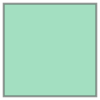

In [3]:
square

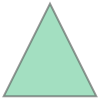

In [4]:
triangle

> **Ex. 6.1.2 ** What is the spatial difference of square subtracted triangle? What is the union?

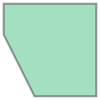

In [5]:
square.difference(triangle)

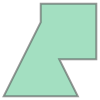

In [6]:
square.union(triangle)

> **Ex. 6.1.3** Make a GeoSeries of `square`, `triangle`. Plot the geoseries.

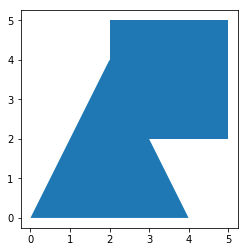

In [7]:
gpd.GeoSeries([square, triangle]).plot()

### Part 6.2: Working with house sale prices

We have downloaded the shapes of the current Danish municipalities and parishes from [here](https://download.kortforsyningen.dk/content/danmarks-administrative-geografiske-inddeling-110000) for you. They are available [here](https://github.com/abjer/tsds/tree/master/data/dk_admin_shapes/) in the course repo. 

#### Basic operations with Geopandas

> **Ex. 6.2.1 ** Load the municipalities data. 
- What is the CRS of the dataframe - what projection does it correspond to? 
- Which three munipalities have the largest area?

> Note: to find the entire area of a municipality which consists of island etc. you can use the `unary_union` method for GeoSeries.

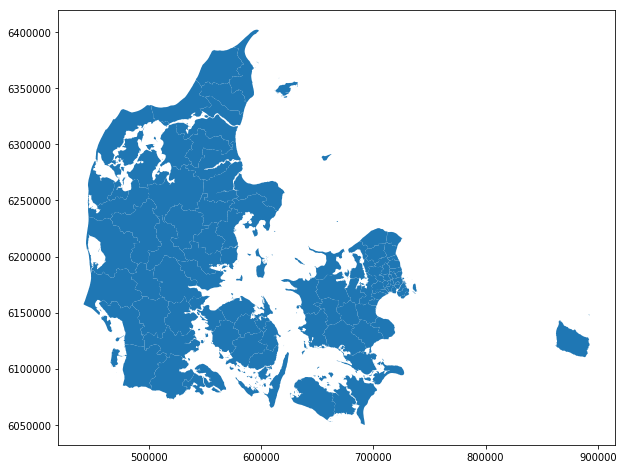

In [8]:
municipalities = gpd.read_file('data/KOMMUNE.shp')
municipalities.plot(figsize=(14,8))

In [9]:
mun_3_largest = municipalities.groupby('KOMNAVN').apply(lambda d: d.unary_union.area).nlargest(3)
print('three largest:\n\n',mun_3_largest)

three largest:

 KOMNAVN
Ringkøbing-Skjern    1.494549e+09
Viborg               1.419921e+09
Herning              1.322592e+09
dtype: float64


> **Ex. 6.2.2** Make two boolean series as follows. 
> - first: row is True if corresponding the row shape is in the Capital Region or Sealand Region (i.e. `'Region Hovedstaden', 'Region Sjælland'`) 
> - second: row is True if the  the row geometry is ***not*** in Bornholm or nearby (i.e. `'Bornholm', 'Christiansø'`)

> Finally make a combined series which takes the value True if both holds, otherwise False and use this series to select rows in the GeoDataFrame. 


> *Hint*: recall that we can check if a series elements are elements in a series using the `isin` method


In [10]:
sealand_reg = municipalities.REGIONNAVN.isin(['Region Hovedstaden', 'Region Sjælland'])
non_bornholm = ~ municipalities.KOMNAVN.isin(['Bornholm', 'Christiansø'])

municipalities_select = municipalities[sealand_reg & non_bornholm]

> **Ex. 6.2.3** Explain what is the CRS of the GeoDataFrame. How is distance measured using this coordinate system. Extract the extremum values (min,max) in all dimensions.

> *Hint*: extreme values, i.e. bounds, can be found using `.bounds` on a GeoDataFrame (also works on shapes, GeoSeries)

In [11]:
bounds = municipalities_select.bounds
minx, miny = bounds[['minx', 'miny']].min().astype(int) 
maxx, maxy = bounds[['maxx', 'maxy']].max().astype(int) 

#### Interpolation of house prices


In the following two exercises we aim to compute local spatial neighborhood measures of house prices in Sealand and around. We do this by making make a grid of Sealand houseprice data. Thus the exercise will illustrate how to make a interpolation of data which is useful for feature engineering and get a good understanding of the data.

> **Ex. 6.2.4** We are now to construct a 500mx500m grid for Sealand:
- Make a grid of points 500m apart in horizontal and vertical directions that are within the extremum values of Sealand's shape. 
- For each of these points construct a square polygon assuming that the point is the south west corner of the square. 
- Select all the house sales that take place within the Sealand and nearby islands.

> *Hint 1:* Once you have created the grid the following function below may be useful for converting into a GeoDataFrame. You need to specify the column names for your x and y coordinates.

> *Hint 2:* We can select the points that intersect by using a spatial join between the house locations and municipalities.

In [12]:
dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}

def cell_coords_to_polygons(square_df, x='e', y='n', dist=500, crs=dk_crs):
    '''
    Convert coordinates to squares in a GeoDataFrame.
       
    Parameters
    ----------
    x : str
        Name of the horizontal coordinate (~longitude)            
    y : str
        Name of the vertical coordinate (~latitude)                        
    dist : int or float
        Size of polygons
    crs : dict
        Coordinate Reference System


    Returns
    ----------
    squares_gdf: geopandas.GeoDataFrame
        This table contains squares as geometry
        and the original data.
    '''
    
    def _to_square_polygon(row):
        '''
        This auxiliary function convert a square's lower,left 
        coordinates to a polygon. 
        
        Parameters
        ----------
        row : pandas.Series
            This is a DataFrame row.            
        
        Returns
        ----------
        poly: shapely.Polygon        
        
        '''
        
        square_coords = ((row[x], row[y]), 
                         (row[x]+dist, row[y]), 
                         (row[x]+dist, row[y]+dist), 
                         (row[x], row[y]+dist))
        
        poly = shapely.geometry.Polygon(square_coords)
        
        return poly
    
    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)
    
    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)
    
    return square_gdf

In [25]:
# make grid dataframe
square_coords = [(x,y) for x in np.arange(minx, maxx, 500) for y in np.arange(miny, maxy, 500)]
square_df = pd.DataFrame(data=square_coords, columns=['e', 'n'])

# convert to geodataframe
square_gdf = cell_coords_to_polygons(square_df)

# make spatial merge
square_gdf_s = gpd.sjoin(square_gdf, municipalities_select) 

> **Ex. 6.2.5** Compute interpolation of house price for each grid cell as follows:
- Load the pre-structured data with house sales prices for the capital region of Denmark
- Make a loop over sale_year
    - Fit a nearest neighbor regression model to the square meter price (i.e. `price_area` for each year)
        - Set number of neighbors to 25 and radius to 25000
    - Apply the model to the grid data and assign as a column
- Plot the grid data for 2012

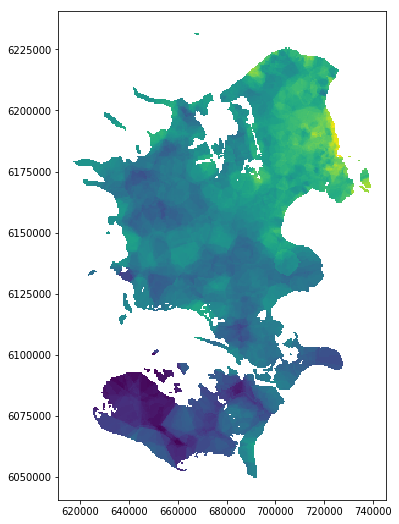

In [32]:
from sklearn.neighbors import KNeighborsRegressor

price_gdf = gpd.read_file('data/houseprices.GeoJSON')

knr = KNeighborsRegressor(n_neighbors=25, radius=25000)

for y in price_gdf.sale_year.unique():

    price_coord = price_gdf[(price_gdf.sale_year==y) & (price_gdf.price_area.between(1000,120000))]\
                            .dropna(subset=['sale_year', 'e', 'n', 'price_area'])
    price_nn = knr.fit(X=price_coord[['e', 'n']].values, 
                       y=price_coord.price_area.values)
    square_gdf_s['p' + str(y)] = np.log10(price_nn.predict(square_gdf_s[['e', 'n']] + 250))
    
square_gdf_s.plot(column='p2012', figsize=(6,9))

### Part 6.3: Exploring OpenStreetMaps through interactive plotting

In this exercise we will play around with OpenStreetMaps (OSM) data. This exercise is short and exploratory but may serve as the beginning of a deeper analysis of features found in OpenStreetMaps. Before we begin you need to download and unzip the shapefile for Denmark [here](https://download.geofabrik.de/europe/denmark-latest-free.shp.zip). 

> **Ex. 6.3.1.** Load the OSM shapefile for `landuse`. What is the CRS for the OSM data?

> *Pro tip*: You can use python module `os` to lookup all files in a given folder. The command is executed as os.listdir(my_path) where my_path provides the path to the relevant folder.

In [36]:
dk_landuse = gpd.read_file('data/gis.osm_landuse_a_free_1.shp')

> **Ex. 6.3.2.** Select the forest features and extract the lat, lon and from centroid.

In [37]:
dk_forest = dk_landuse[dk_landuse.fclass=='forest'].copy()

geom_centroid = dk_forest.geometry.centroid
dk_forest['lon'] = geom_centroid.x
dk_forest['lat'] = geom_centroid.y

> **Ex. 6.3.3.** Select the rows that are in Sealand or surrounding isles (you can reuse your answer to 6.1.3). Note make sure that the CRS of the GeoDataFrames match.

In [105]:
dk_forest_sealand = gpd.sjoin(municipalities_select.to_crs(epsg=4326), dk_forest)

> **Ex. 6.3.4.** Make a folium plot of the forest centroids in Sealand or nearby.

> *Hint:* the folium plugin called `FastMarkerCluster` can quickly plot many points. Note another folium plugin is called `MarkerCluster` and can plot points which have names. 

> You can use the below code to get you started with a plot beginning in Copenhagen:

>```
m = folium.Map(location=[55.7, 12.5],
               tiles='Stamen Toner',
               zoom_start=10)
```

In [107]:
from folium.plugins import FastMarkerCluster

m = folium.Map(location=[55.7, 12.5],
               tiles='Stamen Toner',
               zoom_start=10)

coords = [list(r) for r in dk_forest_sealand[['lat','lon']].values]

FastMarkerCluster(data=coords).add_to(m)

m